# Spark Approach

## Integrating everything as a spark DataFrame

In [ ]:
# import pyspark as ps
# spark = (ps.sql.SparkSession.builder 
#         .master("local[4]") 
#         .appName("sparkSQL exercise")
#         .config("spark.sql.caseSensitive", "true")
#         .getOrCreate()
#         )
# sc = spark.sparkContext

# peer = spark.read.json('new.json')

# peer.printSchema()

# peer.createOrReplaceTempView("peer")

# result = spark.sql("""SELECT lang, COUNT(lang)
#             FROM peer 
#             GROUP BY lang
#             """)

# result.show()

# Manual Approach using Open and Json

In [1]:
import json
from tqdm import tqdm # google this
journals = []
idx = 0

with open('dblpv13.json',"r") as fp:
     for line in tqdm(fp):
        if idx > 1500000:
            break
        try:
            if len(line) < 3:
                continue
            strip_line = line.strip(',')
            journals.append(json.loads(strip_line))
            idx += 1
        except:
            print('fail')
            try:
                strip_line = line.strip(',')
                journals.append(json.loads(strip_line))
                idx += 1
            except:
                idx += 1
                pass

1500002it [02:59, 8370.93it/s] 


## Converting Import to Pandas and Defining Methods to Use

In [2]:
import pandas as pd
journal_df = pd.DataFrame(journals, columns = journals[0].keys())

In [53]:
def plot_counters(count_set,ax, num = 20, title = 'Frequency of Keywords', rotation = 90, **kwargs):
    '''
    Helps plot bar plots using the count_set as input. 
    num is number of most common in counter
    **kwargs are similar to plt.bar(**kwargs)
    '''
    try:
        assert(type(count_set) == type(Counter()))
        
        
        labels, values = zip(*count_set.most_common(num))
        indexes = np.arange(len(labels))
        ax.bar(indexes, values, **kwargs)
        ax.set_title(title)
#         ax.set_xticks(indexes + 0.5, labels, rotation = 90)
        ax.set_xticks(indexes)
        ax.set_xticklabels(labels, rotation = rotation)
    except Exception as e:
        print(e, "Assertion Error! Needs counter for input")

In [4]:
def check_column(column):
    try:
        assert(type(column) == pd.Series)
        assert(len(column) == column.shape[0])
    except AssertionError:
        print('Incorrect Type of Input')

def counter_column(column, key = None, last = False, err = False):
    '''
     Identifies most common attributes of a given Series. Faster Counter
     dict_ refers to if subquery is dictionary. False is for list
     key = specific key in dictionary (assuming dict_ is true)
     last = identify first or last item in list
     err = return error counter
    '''
    from tqdm import tqdm 
    
    check_column(column)
    count_items = Counter()
    errors = Counter()
    idx = 0
    for items in tqdm(column):
#         if idx > 500: #Limit breaks if required for debugging
#             break
        try:
            if len(items) == 0:
                    idx += 1
                    continue
            if (key is not None) and (type(items) == dict):
                if (len(items) == 1):
                    if count_items.get(items[key]) is None:
                        count_items[items[key]] = 1
                    else:
                        count_items[items[key]] += 1
                    idx += 1
                else:
                    if count_items.get(items[key]) is None:
                        count_items[items[key]] = 1
                    else:
                        count_items[items[key]] += 1
                    idx += 1
            elif (key is not None):
                if (len(items) == 1):
                    if count_items.get(items[-last][key]) is None:
                        count_items[items[-last][key]] = 1
                    else:
                        count_items[items[-last][key]] += 1
                    idx += 1
                else:
                    if count_items.get(items[-last][key]) is None:
                        count_items[items[-last][key]] = 1
                    else:
                        count_items[items[-last][key]] += 1
                    idx += 1
            elif type(items) == list:    
                if len(items) == 1:
                    if count_items.get(items[-last]) is None:
                        count_items[items[-last]] = 1
                    else:
                        count_items[items[-last]] += 1
                    idx += 1
                else:
                    if count_items.get(items[-last]) is None:
                        count_items[items[-last]] = 1
                    else:
                        count_items[items[-last]] += 1
            else:    
                if len(items) == 1:
                    if count_items.get(items) is None:
                        count_items[items] = 1
                    else:
                        count_items[items] += 1
                    idx += 1
                else:
                    if count_items.get(items) is None:
                        count_items[items] = 1
                    else:
                        count_items[items] += 1
                    idx += 1
        except Exception as e:
            e = str(e)
            if errors.get(e) is None:
                errors[e] = 1
            else:
                errors[e] += 1
#             print("error ", e ,idx)
            idx+=1
            pass
    if err:
        return count_items, errors
    return count_items

In [5]:
def df_reindex(df, series):
    '''
    Verifies column is an appropriate series
    
    Reindexes series to fit existing dataframe index with no loss.
    
    Goes up to index only - use with identical sized dataframe and pandas series
    '''
    check_column(series)
    try:
        assert(len(df) == len(series))
        index_df = pd.DataFrame(df.index, index = np.arange(len(df.index)), columns = ['index'])
        index_df['new'] = series
        index_df = index_df.set_index('index')
        return index_df
    except:
        print("Assertion Error! Different sized dataframe or column")
        pass
    
    
    

In [6]:
def add_column(df, orig_col, new_col, key = None, last = False):
    '''
     Extracts Information from internal dictionaries or lists contained in DataFrame original column
     Adds as new column to original df
     Returns error counter with number of errors encountered.
     
     key = specific key in dictionary (assuming line is dictionary - will return emtpy list otherwise)
     last = identify first or last item in list
    '''
    from tqdm import tqdm
    temp_df = pd.Series(np.nan, index = np.arange(len(df.index)))
    errors = Counter()
    idx = 0
    for items in tqdm(df[orig_col]):
        try:
            if len(items) == 0:
                    idx += 1
                    continue
            if (key is not None) and (type(items) == dict):
                if (len(items) == 1):
                    temp_df.loc[idx] = items[key]
                    idx += 1
                else:
                    temp_df.loc[idx] = items[key]
                    idx += 1
            elif (key is not None):
                if (len(items) == 1):
                    temp_df.loc[idx] = items[-last][key]
                    idx += 1
                else:
                    temp_df.loc[idx] = items[-last][key]
                    idx += 1
            else:    
                if (len(items) == 1):
                    temp_df.loc[idx] = items[-last]
                    idx += 1
                else:
                    temp_df.loc[idx] = items[-last]
                    idx += 1
               
        except Exception as e:
            e = str(e)
            if errors.get(e) is None:
                errors[e] = 1
            else:
                errors[e] += 1
#             print("error at ", idx, ". ", e)
            idx+=1
            pass
    
    temp_df = df_reindex(df, temp_df)
    df[new_col] = temp_df
    del temp_df
    
    return errors
    

# Extracting All Information From Dataframe

In [7]:
#Counting the number of keywords, authors, urls, etc 
journal_df['n_keywords'] = journal_df.keywords.str.len()
journal_df['abstract_length'] = journal_df.abstract.str.len()
journal_df['n_authors'] = journal_df.authors.str.len()
journal_df['n_url'] = journal_df.url.str.len()

In [8]:
import numpy as np
from collections import Counter
add_column(journal_df, 'authors', 'last_author', key = 'name', last = True)
add_column(journal_df, 'authors', 'first_author', key = 'name')
add_column(journal_df, 'venue', 'venue_name', key = 'raw')
add_column(journal_df, 'keywords', 'first_keyword')

100%|██████████| 1500001/1500001 [01:17<00:00, 19397.88it/s]


Counter({"object of type 'float' has no len()": 516})

# Analyzing the Data

## Questions to Answer:

### General Data
* Amount of journal releases over the number of years
* How much has no or negligible citations (i.e. junk journals)?
    * This would assume either 0 citations and/or no author
    * What percentage is this of total?
* Of the junk citations - who are the worst offenders?
    * Look at Authors and Venues
    * Do they have a common area or tend to use a specific keyword?
    * Limit to top 10

###  Focused Data  
* Limit the citations to be something considered influential. 10 or more citations is considered to be solid.
    * Check the distribution of citations. It should be heavily focused to one-side
* What are the top ten venues, authors and keywords?
* Of the Top 10 everything - what is the distribution of citations for each?
* Is there a difference between the #1 and #10 source? What about #5 and #10?
    * Repeat for each venue, authors, keywords
* Is there a statistically significant difference between the #1 venue and #1 author?
    

# General Data

**Question 1** - Amount of journal releases over the number of years

In [9]:
#Isolates to releases that occur during 1500 through 2021 (current year) - unknown year otherwise.
releases_year = journal_df[['year', '_id']].groupby('year').count().reset_index()
releases_year = releases_year[(releases_year['year'] > 1500) & (releases_year['year'] < 2022)]

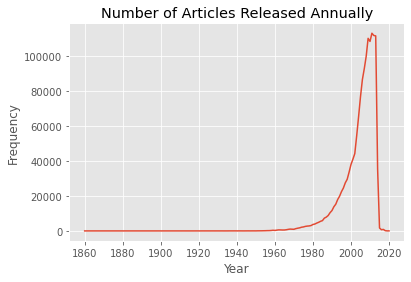

In [60]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.plot(releases_year.iloc[:, 0], releases_year.iloc[:,1])
plt.title("Number of Articles Released Annually")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.savefig('img/annual_article_release.png')

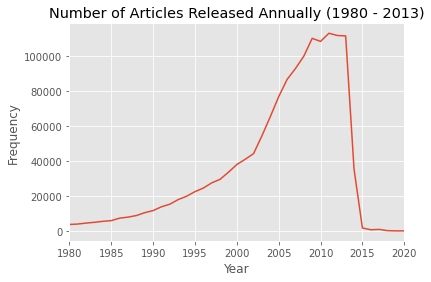

In [61]:
plt.plot(releases_year.iloc[:, 0], releases_year.iloc[:,1])
plt.title("Number of Articles Released Annually (1980 - 2013)")
plt.xlim(1980, 2020)
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.savefig('img/annual_article_release_1980-2013.png')

**Question 2**
* How much has no or negligible citations (i.e. junk journals)?
    * This would assume either 0 citations and/or no author
* What percentage is this of total?

In [12]:
#Out of 99967 entries - where year provided was between 1500 and 2020 (0.03% removal)
#73044 had 1 or more citations. ~ 73% had been cited more than once.
#0.8% of those entries had been cited more than 1000 times

filter_journal = journal_df[(journal_df['year'] > 1500) & (journal_df['year'] < 2022)]
filter_journal_citations =  filter_journal[(filter_journal['n_citation'] > 0) & (filter_journal['n_authors'] > 0)]
keywords = len(filter_journal_citations[filter_journal_citations.n_keywords > 0])
venues = len(filter_journal_citations[filter_journal_citations.n_keywords > 0])

total = len(journal_df)
year_minus = len(filter_journal)
cit_1 = len(filter_journal_citations)

print(f'''There are {total} total entries. Of those, {year_minus} where release year was noted between 1500 and 2020. ({round((total - year_minus)/total * 100, 2)}% removal) 
Of those {cit_1} had 1 or more citations and an author. ~ {round(cit_1/year_minus*100,1)}% had been cited more than once. ({round((year_minus - cit_1)/year_minus * 100, 2)}% removal)
There are {round(keywords,2)} journals with keywords notated, roughly {round((cit_1 - keywords)/cit_1 * 100,2)}% have no keywords''')

There are 1500001 total entries. Of those, 1499718 where release year was noted between 1500 and 2020. (0.02% removal) 
Of those 1224240 had 1 or more citations and an author. ~ 81.6% had been cited more than once. (18.37% removal)
There are 1070477 journals with keywords notated, roughly 12.56% have no keywords


In [13]:
del journal_df
del journals

**Question 3**

* Of the junk citations - who are the worst offenders?
    * Look at Authors and Venues
    * Do they have a common area or tend to use a specific keyword?
* Limit to top 10

In [14]:
junk_citations = filter_journal[(filter_journal['n_citation'] == 0) | (filter_journal['n_authors'] == 0)]

first_name_all = counter_column(junk_citations['authors'], key = 'name')
last_name_all = counter_column(junk_citations['authors'], key = 'name', last = True)
venue_all = counter_column(junk_citations['venue'], key = 'raw')
keywords_all = counter_column(junk_citations['keywords'])

100%|██████████| 270869/270869 [00:00<00:00, 499919.66it/s]


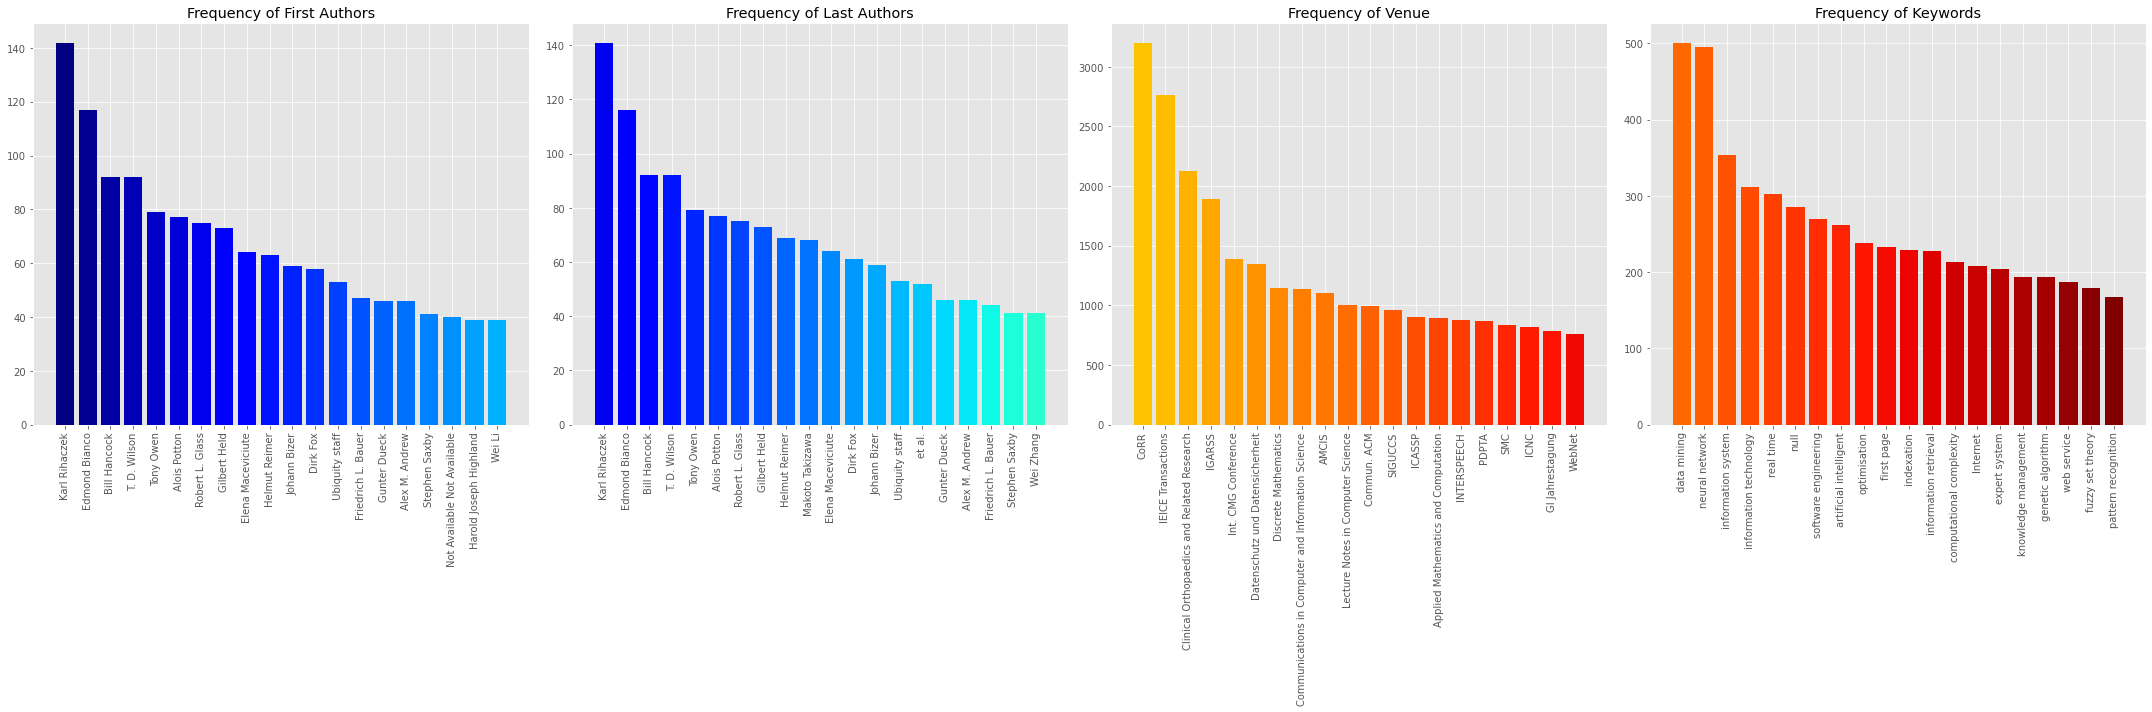

In [62]:
fig, axs = plt.subplots(ncols = 4, figsize = (30, 10))
lst = [(first_name_all, 'Frequency of First Authors', plt.cm.jet(np.linspace(0.0,.3,20))),
       (last_name_all, 'Frequency of Last Authors', plt.cm.jet(np.linspace(0.1,.4,20))), 
       (venue_all, 'Frequency of Venue', plt.cm.jet(np.linspace(0.7,.9,20))), 
      (keywords_all, 'Frequency of Keywords', plt.cm.jet(np.linspace(0.8,1,20)))]

for idx, ax in enumerate(axs.flatten()):
    plot_counters(lst[idx][0], ax, num = 20, title = lst[idx][1], rotation = 90, color = lst[idx][2])

plt.tight_layout()
plt.savefig('img/Frequency_Layouts.png')

In [16]:
first_name_all.most_common(10), last_name_all.most_common(12)

([('Karl Rihaczek', 142),
  ('Edmond Bianco', 117),
  ('Bill Hancock', 92),
  ('T. D. Wilson', 92),
  ('Tony Owen', 79),
  ('Alois Potton', 77),
  ('Robert L. Glass', 75),
  ('Gilbert Held', 73),
  ('Elena Maceviciute', 64),
  ('Helmut Reimer', 63)],
 [('Karl Rihaczek', 141),
  ('Edmond Bianco', 116),
  ('Bill Hancock', 92),
  ('T. D. Wilson', 92),
  ('Tony Owen', 79),
  ('Alois Potton', 77),
  ('Robert L. Glass', 75),
  ('Gilbert Held', 73),
  ('Helmut Reimer', 69),
  ('Makoto Takizawa', 68),
  ('Elena Maceviciute', 64),
  ('Dirk Fox', 61)])

In [17]:
names, value = zip(*last_name_all.most_common(12))

lst = []
remove_lst = ['&NA;', 'Not Available Not Available', 'null']
name = [name for name in names if name not in remove_lst]
junk_citations[junk_citations['last_author'].isin(name)].groupby(['last_author', 'venue_name']).agg(['count','mean', 'std'])


year  \
                                                                   count   
last_author     venue_name                                                 
Alois Potton    Praxis der Informationsverarbeitung und Kommuni...    76   
Bill Hancock    Computers & Security                                  91   
                Computers and Security                                 1   
Dirk Fox        Datenschutz und Datensicherheit                       60   
                GI-Fachgespräch über Rechenzentren                     1   
...                                                                  ...   
Robert L. Glass Journal of Systems and Software                       38   
                PS Political Science & Politics                        1   
T. D. Wilson    Inf. Process. Manage.                                  1   
                Inf. Res.                                             91   
Tony Owen       Robotica                                              79   

                                                                                 \
                                                                           mean   
last_author     venue_name                                                        
Alois Potton    Praxis der Informationsverarbeitung und Kommuni...  2002.500000   
Bill Hancock    Computers & Security                                1999.989011   
                Computers and Security                              2000.000000   
Dirk Fox        Datenschutz und Datensicherheit                     2006.750000   
                GI-Fachgespräch über Rechenzentren                  1993.000000   
...                                                                         ...   
Robert L. Glass Journal of Systems and Software                     1993.657895   
                PS Political Science & Politics                     1988.000000   
T. D. Wilson    Inf. Process. Manage.                               2001.000000   
                Inf. Res.                                           2007.120879   
Tony Owen       Robotica                                            1990.240506   

                                                                              \
                                                                         std   
last_author     venue_name                                                     
Alois Potton    Praxis der Informationsverarbeitung und Kommuni...  6.549300   
Bill Hancock    Computers & Security                                0.459335   
                Computers and Security                                   NaN   
Dirk Fox        Datenschutz und Datensicherheit                     4.542175   
                GI-Fachgespräch über Rechenzentren                       NaN   
...                                                                      ...   
Robert L. Glass Journal of Systems and Software                     3.633748   
                PS Political Science & Politics                          NaN   
T. D. Wilson    Inf. Process. Manage.                                    NaN   
                Inf. Res.                                           3.463573   
Tony Owen       Robotica                                            1.994963   

                                                                   n_citation  \
                                                                        count   
last_author     venue_name                                                      
Alois Potton    Praxis der Informationsverarbeitung und Kommuni...         76   
Bill Hancock    Computers & Security                                       91   
                Computers and Security                                      1   
Dirk Fox        Datenschutz und Datensicherheit                            60   
                GI-Fachgespräch über Rechenzentren                          1   
...                                                                    

In [18]:
#pd.plotting.scatter_matrix(filter_journal_citations, alpha = 0.25, figsize = (20, 10))

In [26]:
#Percentage of Submissions to Encyclopedias in Junk
encyclopedia_lst = [key for key in venue_all.keys() if 'Encyclopedia' in key]

print(round(sum(venue_all.get(entries) for entries in encyclopedia_lst)/sum(venue_all.values())*100, 2), '% of all citations are Encyclopedias')

1.21 % of all citations are Encyclopedias


## Insights from 'Junk Citations'

* Praxis der Informationsverarbeitung und Kommunikation ceased running in 2016 - means Information processing and communication practice
* SIGGRAPH Computer Animation Festival is a festival - more URL links
* Datenschutz und Datensicherheit - Data Protection and Data Safety


* Almost submissions are all only one author with 0 - negligble keywords tend to get 0 citations though some of the venues are high performing
* Most authors submitted to one journal/ group - if submit to other areas, its only a one off.
* Encyclopedias themselves get cited, but not necessarily the individual contributor


###  Focused Data  
* Limit the citations to be something considered influential. 10 or more citations is considered to be solid.
    * Check the distribution of citations. It should be heavily focused to one-side
* What are the top ten venues, authors and keywords?
* Of the Top 10 everything - what is the distribution of citations for each?
* Is there a difference between the #1 and #10 source? What about #5 and #10?
    * Repeat for each venue, authors, keywords
* Is there a statistically significant difference between the #1 venue and #1 author?

In [27]:
focused_journal =  filter_journal[(filter_journal['n_citation'] >= 10) & (filter_journal['n_authors'] > 0)]

In [28]:
# focused_journal
focused_first = counter_column(focused_journal['authors'], key = 'name')
focused_last = counter_column(focused_journal['authors'], key = 'name', last = True)
focused_venue = counter_column(focused_journal['venue'], key = 'raw')
focused_keyword = counter_column(focused_journal['keywords'])

100%|██████████| 631546/631546 [00:01<00:00, 408618.24it/s]


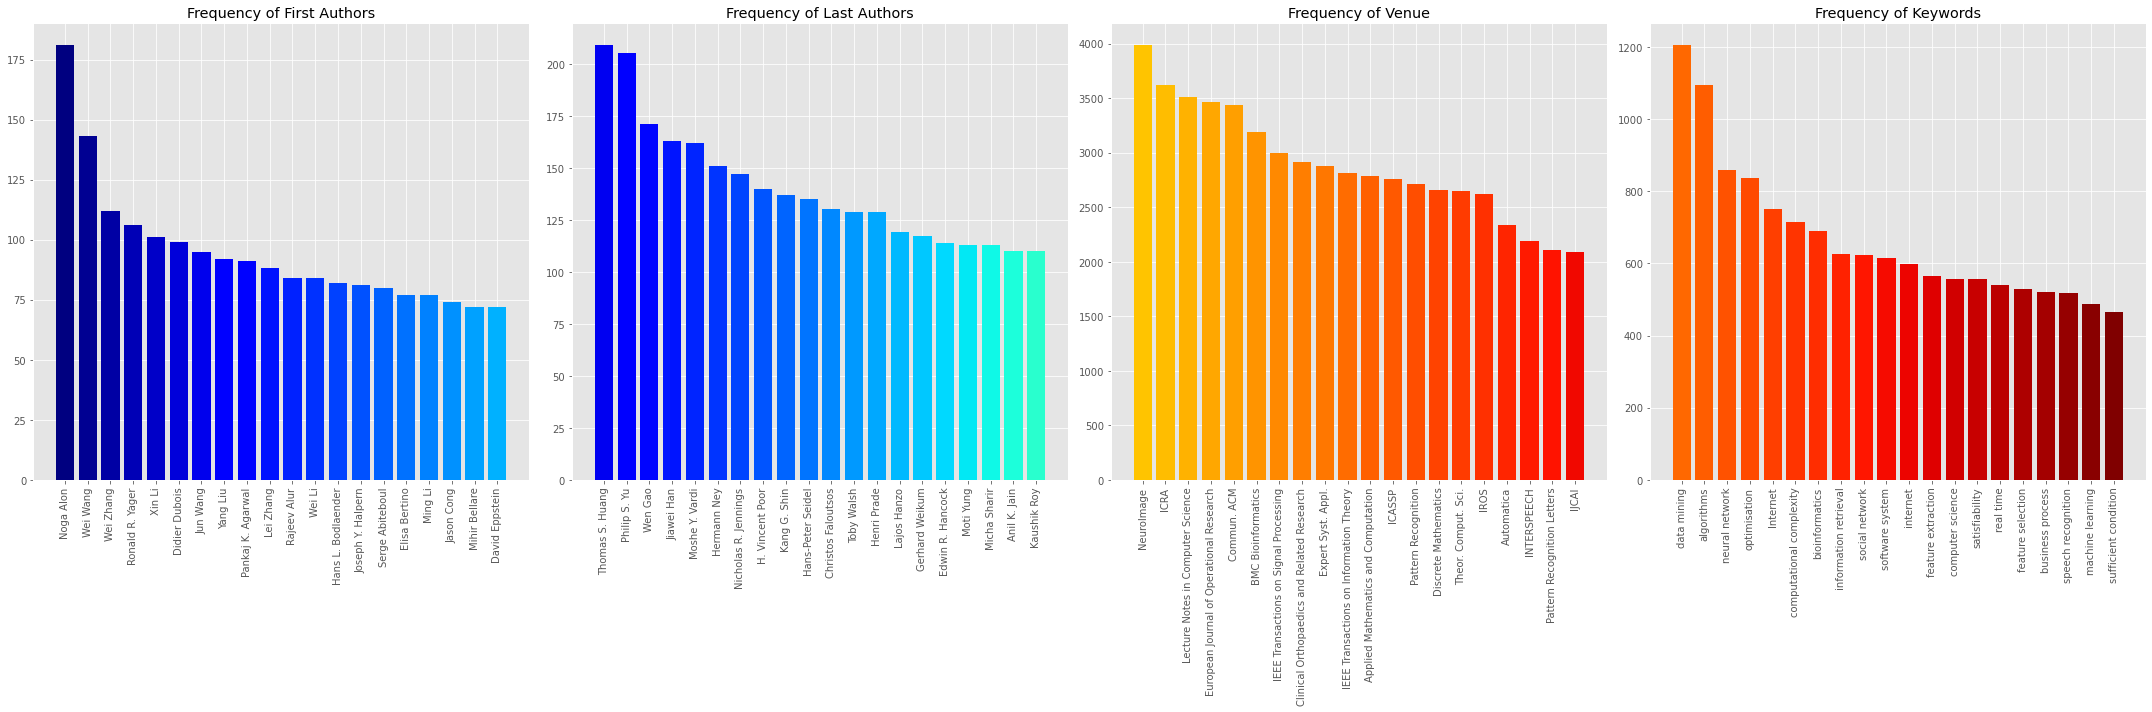

In [65]:
fig, axs = plt.subplots(ncols = 4, figsize = (30, 10))
#green, blue, orange, purple
lst = [(focused_first, 'Frequency of First Authors', plt.cm.jet(np.linspace(0.0,.3,20))),
       (focused_last, 'Frequency of Last Authors', plt.cm.jet(np.linspace(0.1,.4,20))), 
       (focused_venue, 'Frequency of Venue', plt.cm.jet(np.linspace(0.7,.9,20))), 
      (focused_keyword, 'Frequency of Keywords', plt.cm.jet(np.linspace(0.8,1,20)))]

for idx, ax in enumerate(axs.flatten()):
    plot_counters(lst[idx][0], ax, num = 20, title = lst[idx][1], rotation = 90, color = lst[idx][2])

plt.tight_layout()
plt.savefig('img/Focused_Frequency_Layouts.png')

### Question

**What are the top ten venues, authors and keywords?**

In [30]:
last_keys, last_values = zip(*focused_last.most_common(10))
venue_keys, venue_values = zip(*focused_venue.most_common(10))
keyword_keys, keyword_values = zip(*focused_keyword.most_common(10))

print(f'Top 10\n\nLast Authors:\n{last_keys}\n\nVenues:\n{venue_keys}\n\nKeywords:\n{keyword_keys}')

Top 10

Last Authors:
('Thomas S. Huang', 'Philip S. Yu', 'Wen Gao', 'Jiawei Han', 'Moshe Y. Vardi', 'Hermann Ney', 'Nicholas R. Jennings', 'H. Vincent Poor', 'Kang G. Shin', 'Hans-Peter Seidel')

Venues:
('NeuroImage', 'ICRA', 'Lecture Notes in Computer Science', 'European Journal of Operational Research', 'Commun. ACM', 'BMC Bioinformatics', 'IEEE Transactions on Signal Processing', 'Clinical Orthopaedics and Related Research', 'Expert Syst. Appl.', 'IEEE Transactions on Information Theory')

Keywords:
('data mining', 'algorithms', 'neural network', 'optimisation', 'Internet', 'computational complexity', 'bioinformatics', 'information retrieval', 'social network', 'software system')


### Question

**Of the Top 10 everything - what is the distribution of citations for each?**

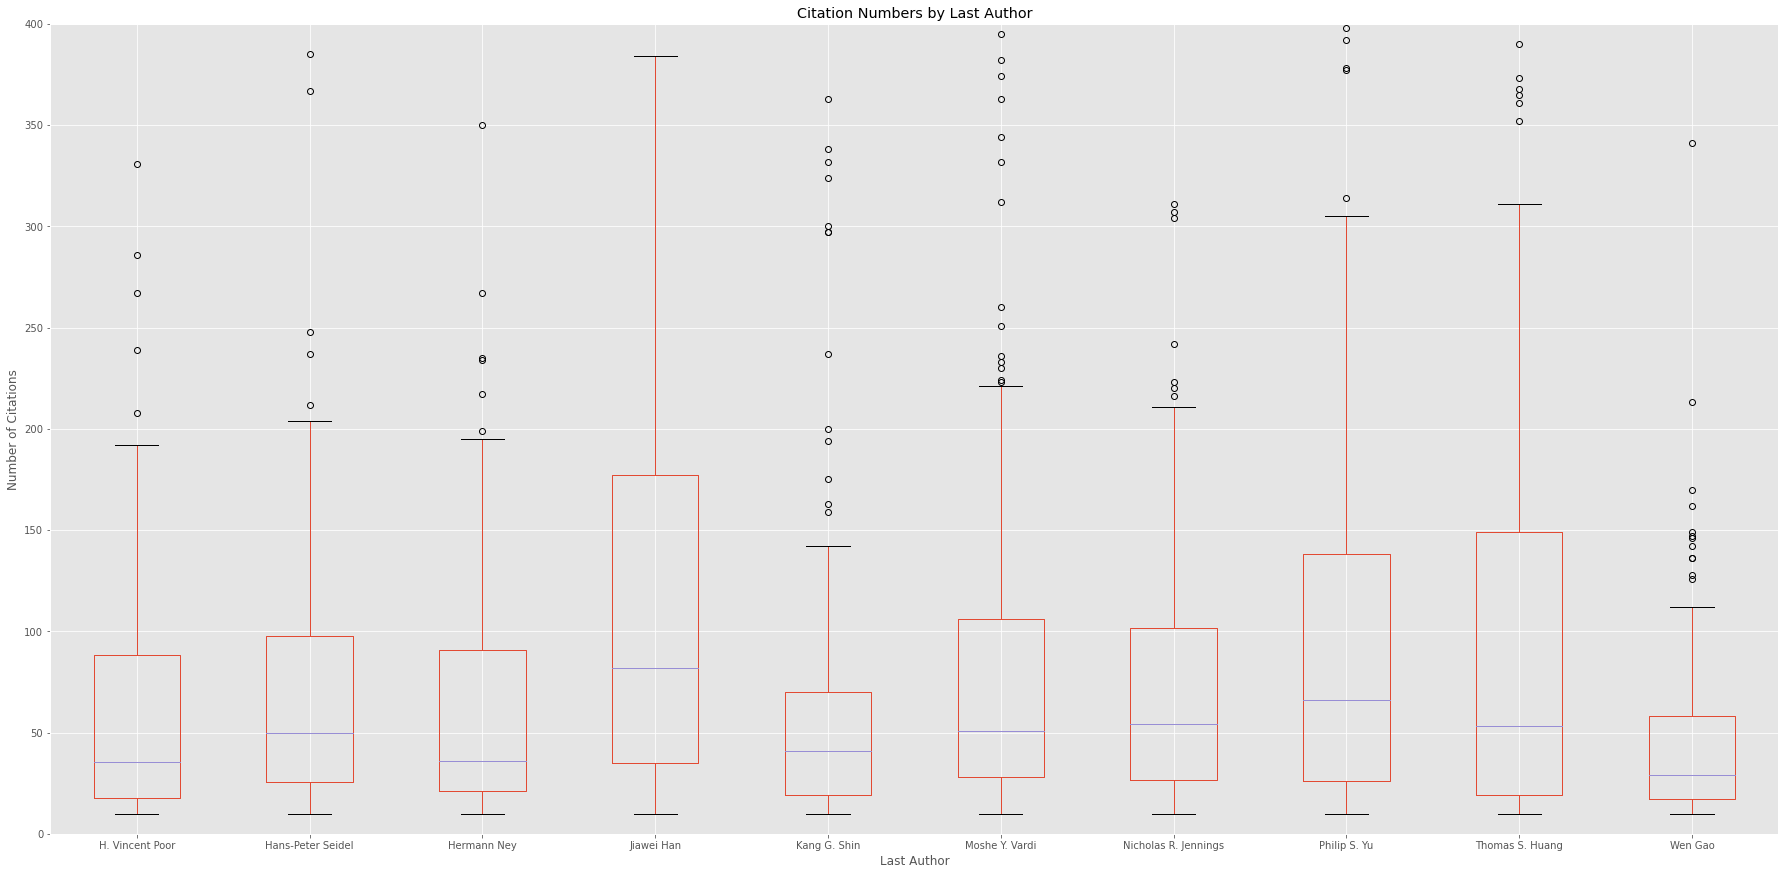

In [77]:
last_author = focused_journal[focused_journal['last_author'].isin(last_keys)][['last_author', 'n_citation']]#.groupby('last_author').boxplot(column = 'n_citation', by = 'last_author',figsize = (30,6))
last_author.boxplot(by = last_author.columns[0], figsize = (30, 15))
plt.ylim(0,400)
plt.xlabel("Last Author")
plt.ylabel("Number of Citations")
plt.title('Citation Numbers by Last Author')
plt.suptitle('')
plt.savefig('img/Last_author_boxplot.png')

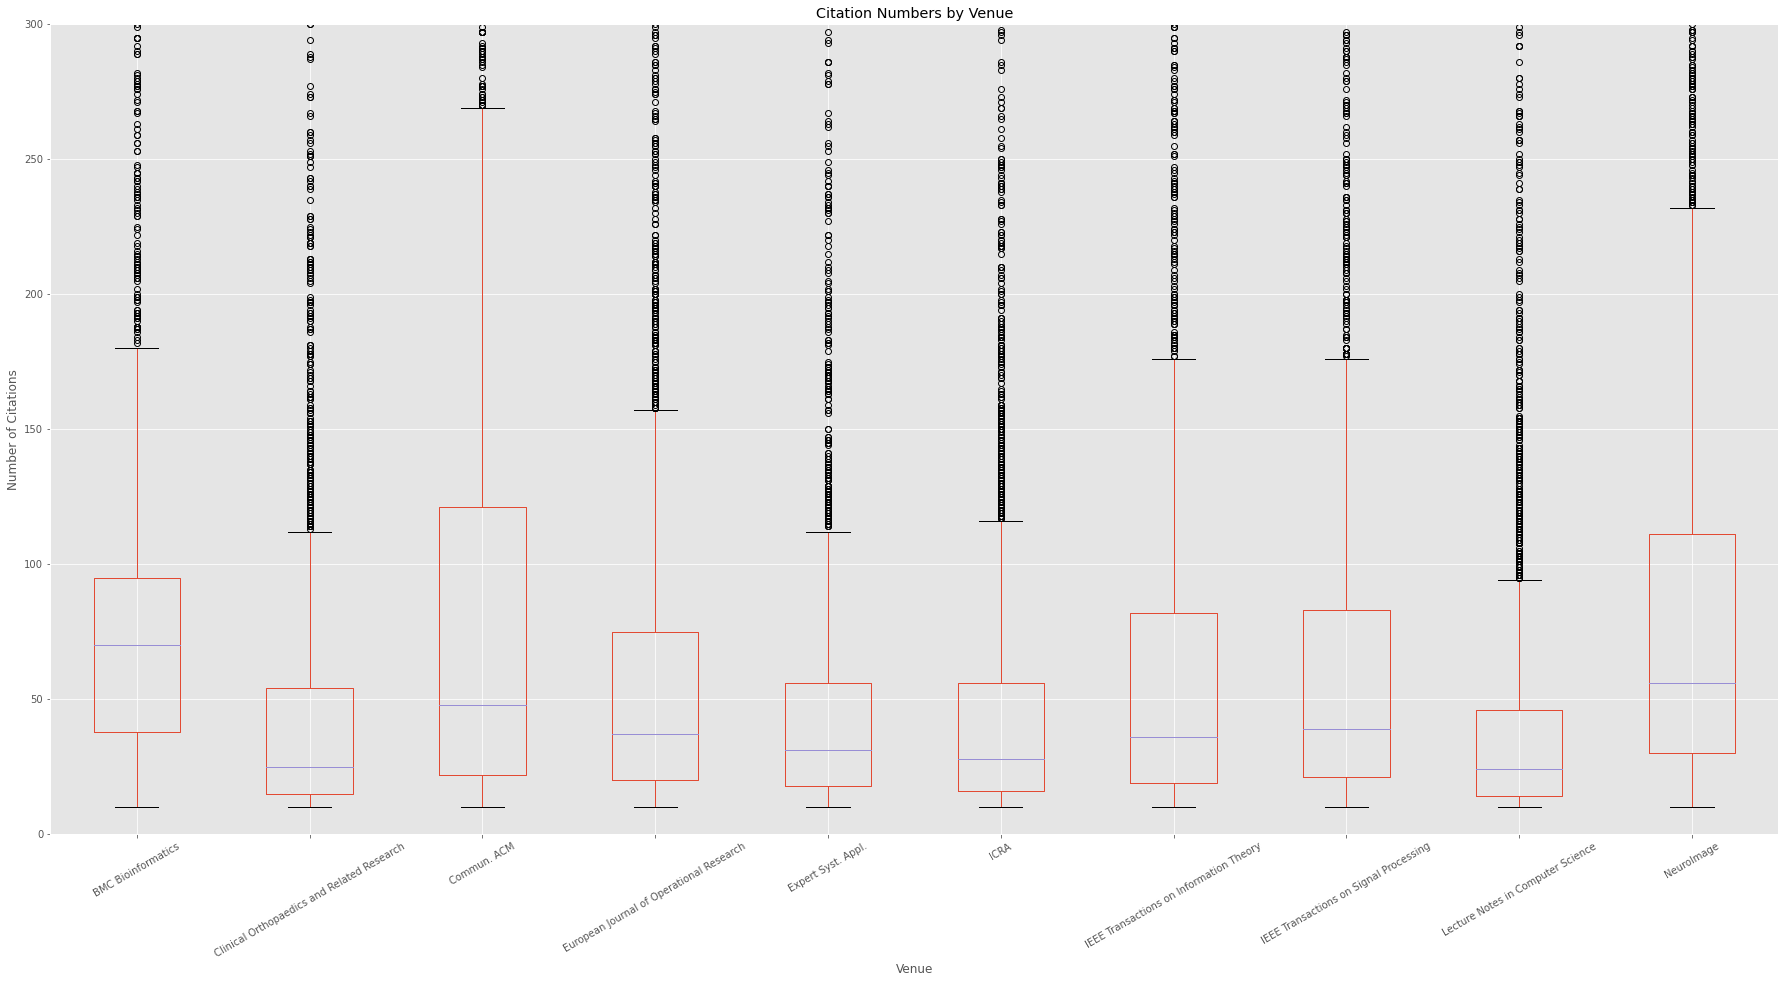

In [80]:
venue = focused_journal[focused_journal['venue_name'].isin(venue_keys)][['venue_name', 'n_citation']]
venue.boxplot(by = venue.columns[0], figsize = (30, 15))
plt.ylim(0,300)
plt.xlabel("Venue")
plt.xticks(rotation = 30)
plt.ylabel("Number of Citations")
plt.title('Citation Numbers by Venue')
plt.suptitle('')
plt.savefig('img/Venue_boxplot.png')

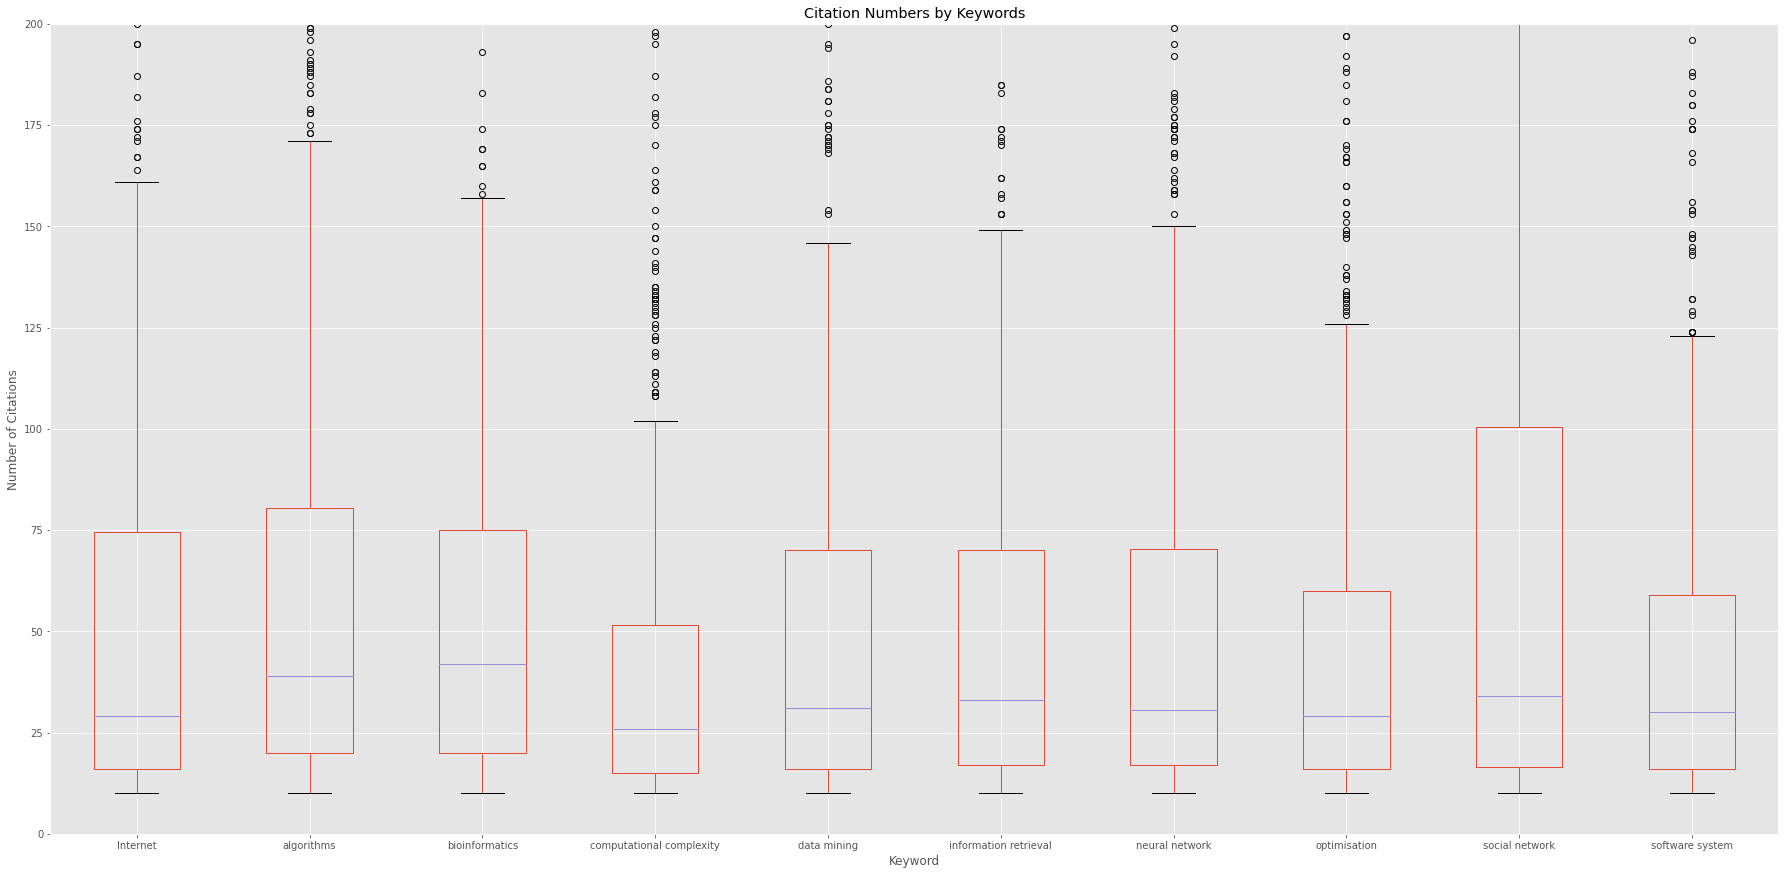

In [83]:
keywords = focused_journal[focused_journal['first_keyword'].isin(keyword_keys)][['first_keyword', 'n_citation']]
keywords.boxplot(by = keywords.columns[0], figsize = (30, 15))
plt.ylim(0,200)
plt.xlabel("Keyword")
plt.ylabel("Number of Citations")
plt.title('Citation Numbers by Keywords')
plt.suptitle('')
plt.savefig('img/keywords_boxplot.png')

### Question

**Plot the p-value distribution across the within each subset**

Repeat for each venue, authors, keywords

Does the frequency of submissions help or no?


### Null Hypothesis: There is no difference between all the most prolific Authors, Venues or Keywords

### Alternate Hypothesis: There is an intergroup difference between the Authors, Venues or Keywords. 

#### Note: Each Hypothesis is independent of one another

##### Alpha = 0.05

In [90]:
import scipy.stats as stats

def plot_pval(df, subset, reference, keys, idx, type_,  alternative = 'greater', **kwargs):
    """
    Plot pvalues of various inputs using mann-whitney-u. Default assumption is that key[idx] is greater.
    subset = group you are investigating
    reference = reference metric used to compare
    last_keys = group of subset (e.g. top 10 authors)
    idx = which individual in last keys
    
    Kwargs are equal to plot requirements
    """
    
    x = np.linspace(1, len(keys), num = len(keys) - 1)
    p_lst = []
    keys_copy = list(keys)
    del keys_copy[idx]
    
    for key in keys_copy:
        diff, p_val = stats.mannwhitneyu(df[df[subset] == keys[idx]][reference], df[df[subset] == key][reference], alternative =  alternative)
        p_lst.append(p_val)
    
    plt.figure(figsize = (20, 10))
    plt.plot(x, p_lst, **kwargs)
    plt.title(f"P-Value of {keys[idx]}'s citations versus other {type_}")
    plt.xticks(ticks = x, labels = keys_copy, rotation = 45)
    plt.axhline(0.05/len(keys), label = 'Failure Threshold', color = 'r')
    plt.xlabel('Authors')
    plt.ylabel('P-value')
    plt.legend()

In [91]:
def plot_multi_pval(df, subset, reference, keys, type_, alternative = 'greater', **kwargs):
    """
    Plot pvalues of various inputs using mann-whitney-u. 
    subset = group you are investigating
    reference = reference metric used to compare
    last_keys = group of subset (e.g. top 10 authors)
    idx = which individual in last keys
    
    Kwargs are equal to plot requirements
    """
    
    x = np.linspace(1, len(keys), num = len(keys))
    
    
    fig, ax = plt.subplots(figsize = (20,10))
    
    for idx in range(len(keys)):
        p_lst = []
        for key in keys:
            diff, p_val = stats.mannwhitneyu(df[df[subset] == keys[idx]][reference], df[df[subset] == key][reference], alternative = alternative)
            p_lst.append(p_val)
    
        ax.plot(x, p_lst, label = keys[idx], **kwargs)
        
    plt.title(f"P-Value of {type_}'s citations versus others")
    plt.xticks(ticks = x, labels = keys, rotation = 0)
    ax.axhline(0.05/len(keys), label = 'Failure Threshold', color = 'r')
    plt.xlabel('Authors')
    plt.ylabel('P-value')
    plt.legend()

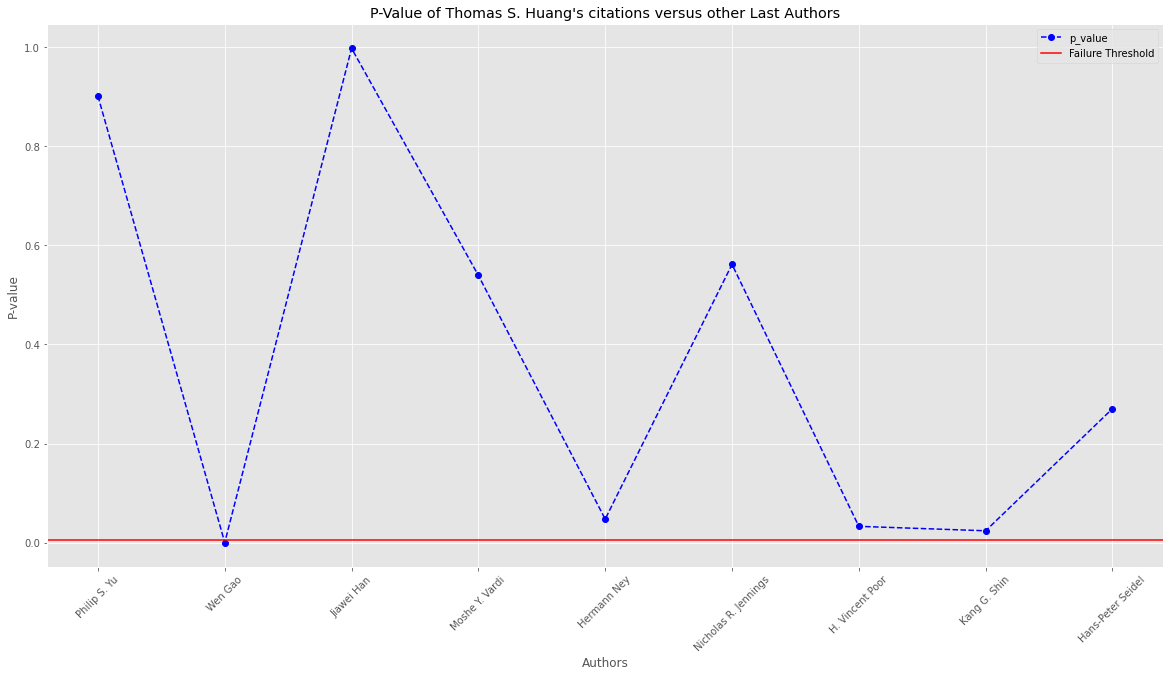

In [92]:
# plot_multi_pval(last_author, 'last_author', 'n_citation', last_keys, 'Last Authors', marker = 'o', linestyle = 'dashed')
plot_pval(last_author, 'last_author', 'n_citation', last_keys, 0, 'Last Authors', label = 'p_value', marker = 'o', linestyle = 'dashed', color = 'blue')
plt.savefig('img/last_author_pval.png')

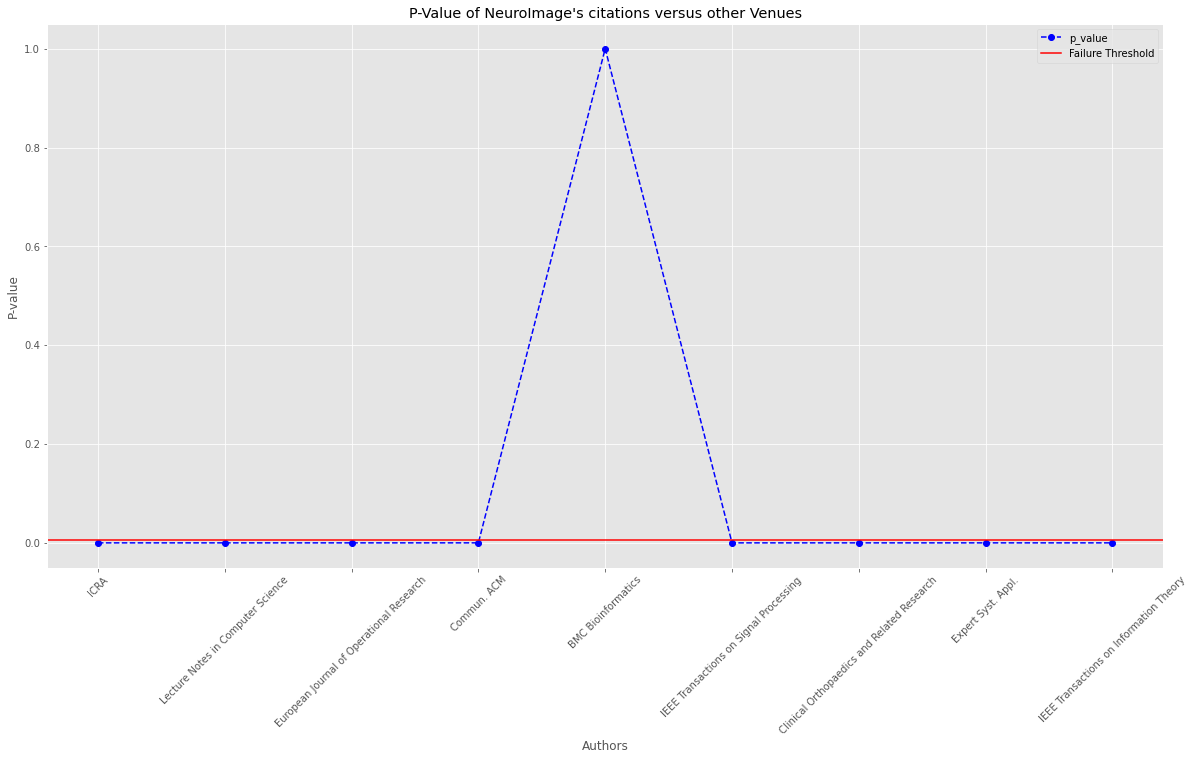

In [93]:
plot_pval(venue, 'venue_name', 'n_citation', venue_keys, 0, 'Venues', label = 'p_value', marker = 'o', linestyle = 'dashed', color = 'blue')
plt.savefig('img/venue_pval.png')

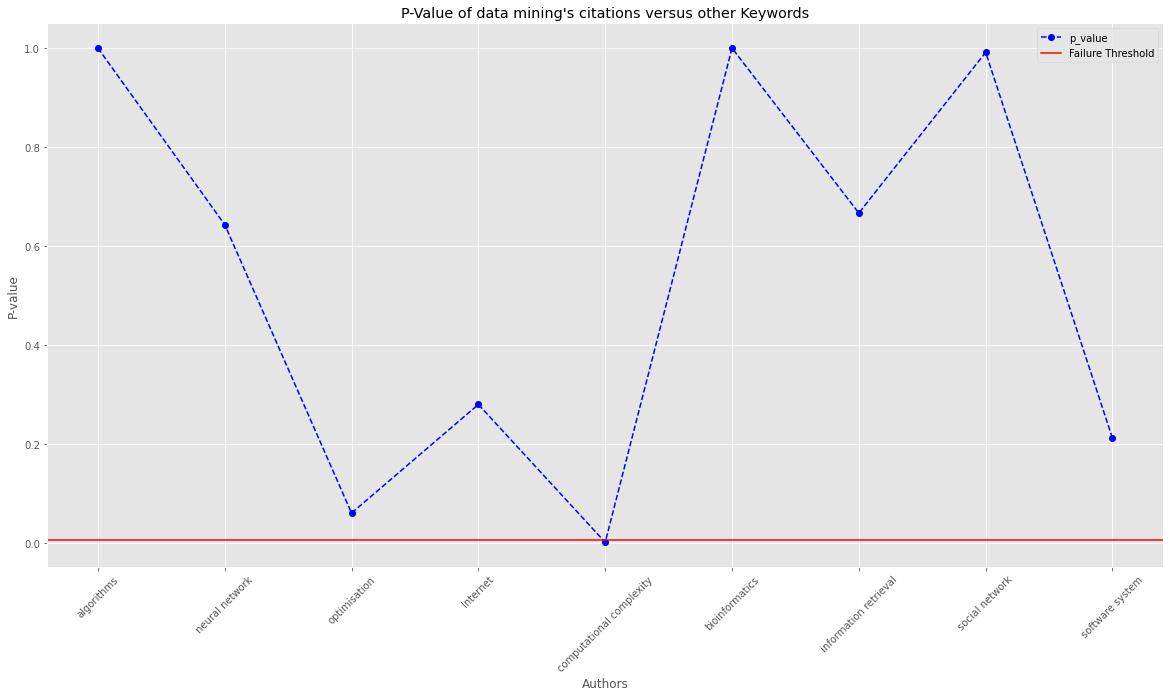

In [94]:
plot_pval(keywords, 'first_keyword', 'n_citation', keyword_keys, 0, 'Keywords', label = 'p_value', marker = 'o', linestyle = 'dashed', color = 'blue')
plt.savefig('img/keywords_pval.png')

## Insights

1. The keyword failed to reject the null hypothesis in most cases. We can conclude there is no stat. sig. difference in keywords aside from computation complexity.
2. The last author failed to reject the null hypothesis in most cases except for 1. This means the most profilic last authors have no stat. sign. impact on # of citations other than vs Saharon.
3. The most prolific venue did have multiple significant difference where it is greater. Only BMC Informatics have similar penetration.

Assuming number of citations indicates it penetration in the scientific community

## Diving Deeper

### We would like to see if there is truly a difference between the most prolific Author and prolific Venue.

#### Null Hypothesis: There is no difference between all the most prolific Author and Venue

#### Alternate Hypothesis: There is an intragroup difference between the Author and Venue
##### Alpha is 0.05

In [49]:
top_author_mixed = sum(focused_journal[focused_journal['last_author'] == last_keys[0]]['venue_name'] == venue_keys[0])
total_top_author = sum(focused_journal['last_author'] == last_keys[0])

print(f'''Of {last_keys[0]}\'s publications, {top_author_mixed} out of {total_top_author} have been published in {venue_keys[0]}.
      All the confounding publications will be removed and verified independently''')

cleaned_author = focused_journal[(focused_journal['last_author'] == last_keys[0]) & (focused_journal['venue_name'] != venue_keys[0])]
cleaned_venue = focused_journal[(focused_journal['last_author'] != last_keys[0]) & (focused_journal['venue_name'] == venue_keys[0])]

Of Thomas S. Huang's publications, 0 out of 209 have been published in NeuroImage.
      All the confounding publications will be removed and verified independently


There IS a statistically significant difference between the Author and Venue. P value is  0.043


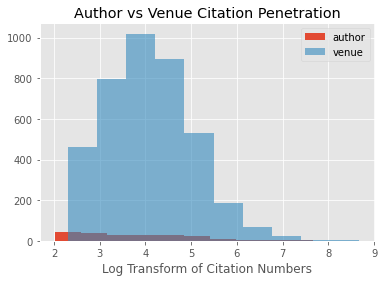

In [95]:
diff, p_val = stats.ttest_ind(cleaned_author['n_citation'], cleaned_venue['n_citation'], equal_var=False)

fig, ax = plt.subplots()
ax.hist(np.log(cleaned_author['n_citation']), align = 'left', alpha = 1, label = 'author')
ax.hist(np.log(cleaned_venue['n_citation']), alpha = 0.6,  label = 'venue')
ax.set_title('Author vs Venue Citation Penetration')
ax.set_xlabel('Log Transform of Citation Numbers')
ax.legend()
plt.savefig('img/Author_v_Venue.png')

if p_val < 0.05:
    print("There IS a statistically significant difference between the Author and Venue. P value is ", round(p_val,3))
else:
    print("There IS NOT a statistically significant difference between the Author and Venue. P value is ", round(p_val,3))